# FACE-TO-FACE INTERACTIONS PATTERNS IN A PRIMARY SCHOOL

### OVERVIEW
This network analysis is aimed to identify and characterize social patterns among school children (6-12 y.o.).     
Its main steps are:

0 DATA PREPROCESSING;                                                                                                     
1 MACROSCOPIC NETWORK DESCRIPTION;                                                                                               
2 MESOSCOPIC NETWORK DESCRIPTION;                                                                                             
        2.1 COMMUNITY DETECTION;                                                                                              
        2.2 COMPARISON BETWEEN COMMUNITY DETECTION ALGORITHMS;                                                                   
        2.3 COMMUNITIES CHARACTERIZATION;                                                                                     


### 0. DATA PREPROCESSING 
In this stage data and their corresponding metadata are imported. 
According to the aim of the analysis, data reffered to the teachers were removed.                           
The dataset we want to obtain has the following features:
- each node is a student;  
- each student is characterized by its gender, its class name and the class year;                   
- each edge is an interaction between two students;                                   
- each interaction is weighted by its frequency, its duration and its average duration (in min).

In [35]:
import pandas as pd 
import numpy as np
from collections import Counter
import statistics as st
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import time
from tqdm import tqdm
from itertools import (combinations, permutations)
import math
import networkx as nx
#!pip install python-louvain
import community
from math import comb
from scipy.stats import (hypergeom,binom)

In [36]:
data = pd.read_csv("dataset_primary_school.csv", index_col=False, header=0).drop('Id', axis=1)  #Interaction id is not useful
data['DURATION'] = data['DURATION']/3                                       #Original durations are multiples of 20 second
data['AVG_DURATION']=round(data['DURATION']/(data['COUNT']),2)              #Minutes of average duration of each iteration
print(data)

      SOURCE  TARGET    DURATION  COUNT  AVG_DURATION
0       1789    1780    6.666667      1          6.67
1       1789    1783  193.333333     23          8.41
2       1789    1787   13.333333      2          6.67
3       1789    1922    6.666667      1          6.67
4       1789    1774   66.666667      6         11.11
...      ...     ...         ...    ...           ...
5534    1687    1765  366.666667     13         28.21
5535    1564    1763    6.666667      1          6.67
5536    1760    1764   13.333333      2          6.67
5537    1766    1764   20.000000      3          6.67
5538    1852    1764    6.666667      1          6.67

[5539 rows x 5 columns]


In [37]:
metadata = pd.read_csv("metadata_primary_school.txt", delim_whitespace=True, header=None)
metadata = metadata.rename(columns = {0 : 'NODE_ID', 1: 'CLASS_NAME', 2 : 'GENDER'})
print(metadata)

     NODE_ID CLASS_NAME GENDER
0       1426         5B      M
1       1427         5B      F
2       1428         5B      M
3       1429         5B      F
4       1430         5B      M
..       ...        ...    ...
237     1916         2A      M
238     1917         2A      F
239     1919         2A      M
240     1920         1B      F
241     1922         2A      F

[242 rows x 3 columns]


In [38]:
metadata["CLASS_NAME"].unique()

array(['5B', '5A', '4A', 'Teachers', '3B', '4B', '2A', '1B', '2B', '1A',
       '3A'], dtype=object)

In [39]:
#Removal of teachers interactions by filtering edges that involve at least one teacher.
meta = metadata[metadata["CLASS_NAME"]!='Teachers'].reset_index(drop=True)
meta = meta[meta['NODE_ID'].isin(set(data['SOURCE']).union(data["TARGET"]))].reset_index(drop=True)
meta['CLASS_YEAR'] = meta.CLASS_NAME.str[:1]
dataset = data[data["SOURCE"].isin(meta["NODE_ID"]) & 
               data["TARGET"].isin(meta["NODE_ID"])].sort_values(["SOURCE", "TARGET"]).reset_index(drop=True)
dataset.head()

,SOURCE,TARGET,DURATION,COUNT,AVG_DURATION
0,1426,1441,40.000000,4,10.00
1,1426,1443,60.000000,9,6.67
2,1426,1471,26.666667,4,6.67
3,1426,1475,33.333333,5,6.67
4,1426,1477,13.333333,2,6.67


In [40]:
meta

,NODE_ID,CLASS_NAME,GENDER,CLASS_YEAR
0,1426,5B,M,5
1,1427,5B,F,5
2,1428,5B,M,5
3,1429,5B,F,5
4,1431,5B,F,5
...,...,...,...,...
223,1916,2A,M,2
224,1917,2A,F,2
225,1919,2A,M,2
226,1920,1B,F,1


In [41]:
def rename(dataframe, node_labels):
    #node_labels is a list of 1 or 2 nodes columns in the dataframe
    dataframe2=dataframe.copy()
    
    if len(node_labels)==1:
        nodes = sorted(list(set(dataframe2[node_labels[0]])))
    else:
        nodes = sorted(list(set(dataframe2[node_labels[0]]).union(dataframe2[node_labels[1]])))
        
    n_nodes = len(nodes)
    
    #Replace the original label with a new one in the ordered range of labels starting from 0:
    for i in node_labels:
        dataframe2[i] = dataframe2[i].replace(to_replace=nodes, value=list(range(0, n_nodes)))
  
    return dataframe2

In [42]:
dataset_r  = rename(dataset, ["SOURCE", "TARGET"])
metadata_r = rename(meta, ['NODE_ID'])
dataset_r

,SOURCE,TARGET,DURATION,COUNT,AVG_DURATION
0,0,9,40.000000,4,10.00
1,0,10,60.000000,9,6.67
2,0,20,26.666667,4,6.67
3,0,21,33.333333,5,6.67
4,0,22,13.333333,2,6.67
...,...,...,...,...,...
5211,227,221,6.666667,1,6.67
5212,227,222,360.000000,35,10.29
5213,227,223,153.333333,19,8.07
5214,227,224,133.333333,10,13.33


In [43]:
metadata_r

,NODE_ID,CLASS_NAME,GENDER,CLASS_YEAR
0,0,5B,M,5
1,1,5B,F,5
2,2,5B,M,5
3,3,5B,F,5
4,4,5B,F,5
...,...,...,...,...
223,223,2A,M,2
224,224,2A,F,2
225,225,2A,M,2
226,226,1B,F,1


### 
### 1. MACROSCOPIC NETWORK DESCRIPTION
In this stage, a general description of the network was carried out in addition to a graphical representation.              
According to the particular network type, the measures used were generalised to their weighted networks form.

### Network topology

In [46]:
#FUNCTION TO COMPUTE THE UNWEIGHTED AND WEIGHTED NODE DEGREE

def degree(dataframe):
    cols = dataframe.columns.to_list()
    
    #1st column: number of different children interacted with
    STATS = pd.DataFrame.from_dict(                                       
        Counter((sorted(list(dataframe.iloc[:,0])+
                        list(dataframe.iloc[:,1])))), orient ='index')
    STATS.columns = ["DEGREE"]
    
    #2nd column: total duration of the daily intactions
    df_temp = pd.concat([dataframe.copy().drop(cols[1], axis=1).rename(columns={cols[0]:'ID'}),
                         dataframe.copy().drop(cols[0], axis=1).rename(columns={cols[1]:'ID'})]).reset_index(drop=True)
    STATS[cols[2]] = df_temp.groupby('ID', as_index=False)[cols[2]].sum()[cols[2]]
    
    #3rd column: number of different interactions
    STATS[cols[3]] = df_temp.groupby('ID', as_index=False)[cols[3]].sum()[cols[3]]
    
    #4th column: average duration of each interaction
    STATS["AVG_DURATION"] = round(STATS[cols[2]]/STATS[cols[3]], 1)
    
    return STATS

In [47]:
stats = degree(dataset_r)
stats.head()

,DEGREE,DURATION,COUNT,AVG_DURATION
0,59,3280.000000,353,9.3
1,28,2113.333333,222,9.5
2,53,2113.333333,243,8.7
3,24,2693.333333,255,10.6
4,22,2306.666667,228,10.1


array([[<AxesSubplot:title={'center':'DEGREE'}>,
        <AxesSubplot:title={'center':'DURATION'}>],
       [<AxesSubplot:title={'center':'COUNT'}>,
        <AxesSubplot:title={'center':'AVG_DURATION'}>]], dtype=object)

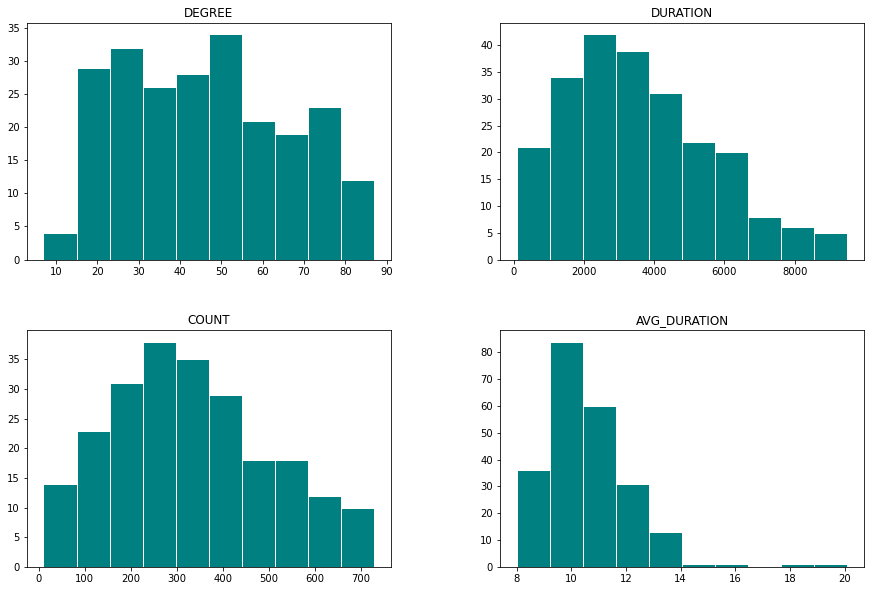

In [48]:
stats.hist(edgecolor='w', color='teal', grid=False, figsize=(15, 10))

In [49]:
stats.describe()

,DEGREE,DURATION,COUNT,AVG_DURATION
count,228.000000,228.000000,228.000000,228.000000
mean,45.754386,3603.040936,331.719298,10.621491
std,19.838361,2063.821288,171.378218,1.603939
min,7.000000,80.000000,10.000000,8.000000
25%,28.000000,2113.333333,201.000000,9.500000
50%,45.000000,3280.000000,316.500000,10.350000
75%,62.000000,4903.333333,443.000000,11.400000
max,87.000000,9500.000000,729.000000,20.100000


In [50]:
#UNWEIGHTED AND WEIGHTED CLUSTERING COEFFICIENT

def clusteringcoeff(df, n_nodes):
    ht = pd.DataFrame(np.zeros([n_nodes, 1]), columns=['LOCAL WEIGHTED CLUSTERING COEFFICIENT'])
    ht2 = pd.DataFrame(np.zeros([n_nodes, 1]), columns=['LOCAL WEIGHTED CLUSTERING COEFFICIENT'])
    triang = pd.DataFrame(np.zeros([n_nodes, 1]))

    for i in range(n_nodes):
        source_target = pd.concat([df[df['SOURCE'] == i]['TARGET'], df[df['TARGET'] == i]['SOURCE']])   #takes all the nodes connected to node i  
        source_target_permutations = pd.DataFrame(list(permutations(source_target, 2)), columns=("SOURCE", "TARGET")) #calculates the permutations for every node i, to have all the couples that could form a triangle
        triang.iloc[i, 0] = len(pd.merge(df.iloc[:, 0:2], source_target_permutations, how="inner"))  #does a merge of the previous dataframe with the orignal dataframe to have all the couples of nodes that, for node i, end up in a triangle, and calculate the number of this triangles

        duration = pd.concat([df[df['SOURCE'] == i]['DURATION'], df[df['TARGET'] == i]['DURATION']])   #couples of weights of the couples of nodes attached to i
        duration_permutations = pd.DataFrame(list(permutations(duration, 2)), columns=['w1', 'w2'])   #permutations
        hg = pd.concat([duration_permutations, source_target_permutations], axis=1)    #merge only on the couples that form triangles
        hg['MG'] = hg['w1'] * hg['w2']
        hg['MG'] = hg['MG'] ** (1 / 2)  
        ht.iloc[i, 0] = round(np.sum(pd.merge(df, hg, on=["SOURCE", "TARGET"], how="inner")['MG']), 1)
        ht2.iloc[i, 0] = np.sum(hg['MG']) / 2

    degree_df = degree(df)  
    triple = pd.DataFrame(degree_df['DEGREE'] * (degree_df['DEGREE'] - 1) / 2)
    clustersing = round(pd.DataFrame((triang.iloc[:, 0] / triple.iloc[:, 0]), columns=['LOCAL CLUSTERING COEFFICIENT']), 2)

    stats = pd.DataFrame({'AVG_CLUSTCOEFFICIENT': round(np.mean(clustersing), 3)[0],
                          'AVG_WEIGHT_CLUSTCOEFFICIENT': round(np.mean(round(ht / ht2, 2)), 3)[0],
                          'GLOBAL_CLUSTCOEFFICIENT': [round(int(np.sum(triang)[0]) / int(np.sum(triple)[0]), 3)],
                          'GLOBAL_WEIGHT_CLUSTCOEFFICIENT': round(np.sum(ht) / np.sum(ht2), 3)[0],
                          'TRIANGLES': [int(int(np.sum(triang)) / 3)],
                          'TRIPLES': [int(np.sum(triple))]}, index=['valori'])
    distributions = pd.concat([clustersing, round(ht / ht2, 2)], axis=1)
    return (stats, distributions)

array([[<AxesSubplot:title={'center':'LOCAL CLUSTERING COEFFICIENT'}>,
        <AxesSubplot:title={'center':'LOCAL WEIGHTED CLUSTERING COEFFICIENT'}>]],
      dtype=object)

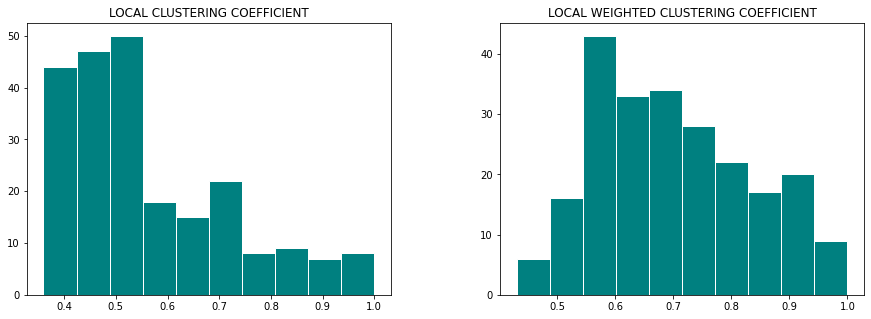

In [51]:
stats2=clusteringcoeff(dataset_r, 228)
stats2[1].hist(edgecolor='w', color='teal', grid=False, figsize=(15, 5))

In [52]:
stats2[1].describe()

,LOCAL CLUSTERING COEFFICIENT,LOCAL WEIGHTED CLUSTERING COEFFICIENT
count,228.000000,228.000000
mean,0.562851,0.699605
std,0.156482,0.131264
min,0.360000,0.430000
25%,0.450000,0.590000
50%,0.510000,0.670000
75%,0.662500,0.790000
max,1.000000,1.000000


In [16]:
stats2[0]

,AVG_CLUSTCOEFFICIENT,AVG_WEIGHT_CLUSTCOEFFICIENT,GLOBAL_CLUSTCOEFFICIENT,GLOBAL_WEIGHT_CLUSTCOEFFICIENT,TRIANGLES,TRIPLES
valori,0.563,0.7,0.472,0.631,43731,278108


### Graphical visualisations
The following network representations were made by the mean of a dedicated software, using an algorithm by which linked nodes attract each other and non-linked nodes push apart, i.e. deskmates will be displaied closer than children who hate each other.


##### Graph n.1


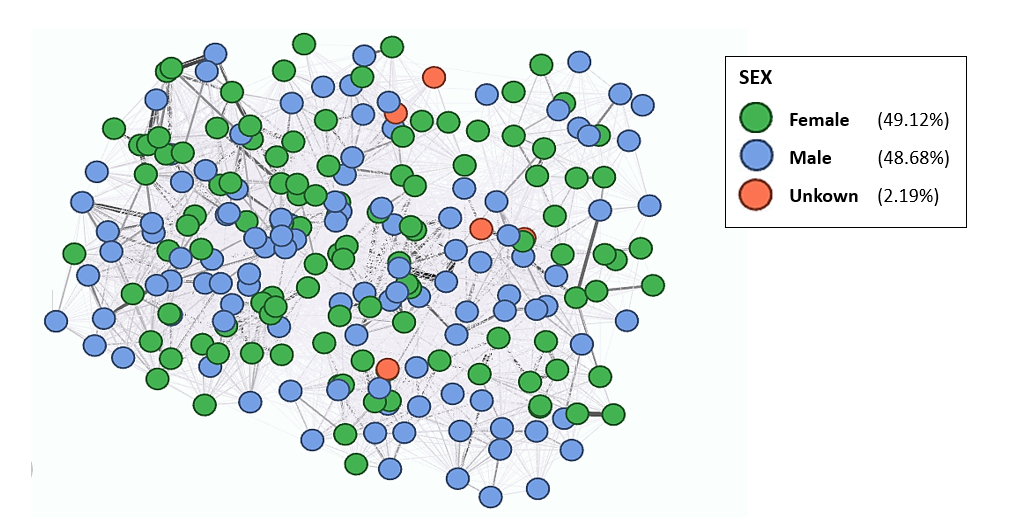

##### Graph n.2


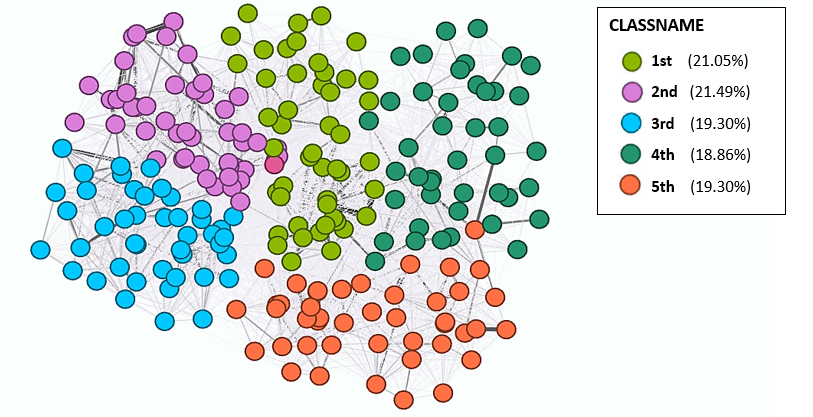

##### Graph n.3


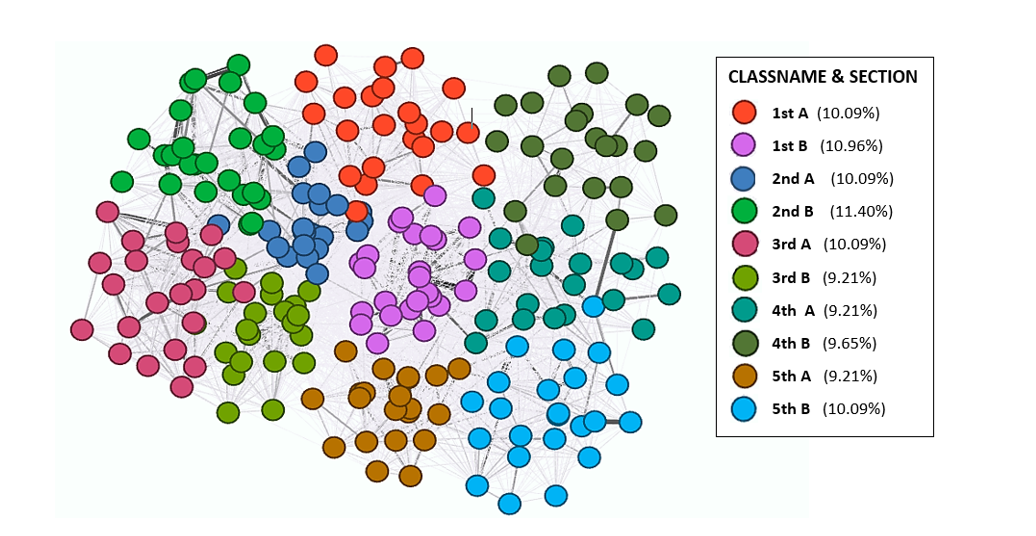

### 2 MESOSCOPIC NETWORK DESCRIPTION

### 2.1 Community detection
Community detection is a tool often used to better understand the structure and the connectivity pattern of a network.           It concernes 
the problem of finding the natural divisions of a network into groups of vertices such that there are 
many edges within groups and few edges between groups.                                            
Given a certain number of communities C, the best partition is obtained using the simulated annealing algorithm in order to maximize the modularity. The number of communities is another parameter to optimize.

In [17]:
#FUNCTION TO COMPUTE THE OVERALL MODULARITY AND THE CONTRIBUTION OF EACH COMMUNITY

def modularity(links_df1, communities, weights_name, Contributes:bool=False):
    links_df = links_df1.copy()          #dataset with rename function applied
    m = np.sum(links_df[weights_name])   #m is the sum of all of the edge weights in the graph   
    
    #Replacing nodes id (index) with its community
    links_df["SOURCE"] = communities[links_df["SOURCE"]]
    links_df["TARGET"] = communities[links_df["TARGET"]]
    contributes = []
    
    for i in set(communities):
        
        #Each community contributes to the overall modularity is given by the difference of two quantities:
        
        # 1. sum of edge weights between nodes within the community i / sum of all the weights in the graph;
        sigma_in_mx2 = (links_df[(links_df["SOURCE"] == i) & 
                                (links_df["TARGET"] == i)].reset_index(drop=True)[weights_name].sum())/m
        
        # 2. sum of edge weights involving at least one member of the community i / 2*sum of all the weights in the graph;
        sigma_tot_mx2 = sigma_tot_mx2 = (((links_df[(links_df["SOURCE"] == i) ^ (links_df["TARGET"] == i)].reset_index(drop=True)[weights_name].sum())+sigma_in_mx2*(2*m))/(m*2))**2
        
        contributes.append(sigma_in_mx2 - sigma_tot_mx2)
    
    return (contributes, sum(contributes)) if Contributes else sum(contributes)

In [18]:
#SETTING THE TEMPERATURE VALUES

#For each random seed in range(100) we obtain a random attribution of the community membership and store
#the modularity into the empty list "modularities" (at the end it will have 100 elements inside). 
modularities = []
for i in range(100):
    np.random.seed(i)
    communities = np.random.choice(range(2), 228)    
    mod = modularity(dataset_r, communities, "DURATION")
    modularities.append(mod)
len(modularities)

100

In [19]:
#We consider all the modularity variations between the values computed before.
pairs = list(combinations(modularities, 2))
all_diff = []
for e in pairs:
    all_diff.append(abs(e[0]-e[1]))
tf, t0 = np.min(all_diff), np.max(all_diff)  
tf, t0
#final temperature   0.000001127   
#initial temperature 0.079001413

(1.1273594696936673e-06, 0.07900141384865769)

In [20]:
#COOLING FUNCTIONS
def cooling_sched(t0, tf, n, N, method):
    
    if method == "exponential":
        beta = -np.log(tf/t0)/N
        x = t0*np.exp(-beta*n)
        
    elif method == "linear":
        eta = (t0 - tf)/N
        x = t0 - eta*n
  
    elif method == "lin-log":
        eta = (t0 - tf)/np.log(N+0.1)
        
        if n==0:    
            x = t0
        else:
            x = t0 - eta*np.log(n+0.1)
        
    elif method == "logarithmic":
        x = t0 / np.log(n+np.exp(1))
        
    else:
        raise ValueError("Wrong method")
        
    return x

In [24]:
#SIMULATED ANNEALING TO FIND THE BEST NETWORK BIPARITITON 

def simulated_annealing(dataset_r, n_nodes, weights_name, cooling_function, t0, tf, N_sim, all_mod:bool=False): 
    #the cooling_function can be choosen among "exponential", "linear", "lin-log", "logarithmic". 
    #np.random.seed(i)
    
    #Empy list to store the modularity values at each iteration.
    if all_mod: all_modularities = []
    
    #Random initial partition of the nodes into two communities. 
    np.random.seed(1)
    communities = np.random.choice([0,1], n_nodes)
    mod0 = modularity(dataset_r, communities, weights_name)  
    
    #Nearby solutions (new bipartitions) starting from the initial random one:
    #we change the community of a random selected node.
    for i in tqdm(range(N_sim)):
        np.random.seed(i)
        random_node = np.random.choice(range(n_nodes), 1)
        comm_node = communities[random_node]
        
        new_communities = communities.copy()
        new_communities[random_node] = comm_node ^ 1  #comm_node=1 -> 0 / comm_node=0 -> 1
        
        mod1 = modularity(dataset_r, new_communities, weights_name)
        
        #Modularity comparison: 
        #Is the new solution better than the previous one?
        
        #Yes -> change solution
        if mod1 >= mod0:
            communities = new_communities.copy()
            mod0 = mod1                      #il copy non serve perche la tupla è immutabile
        
        #No -> change solution with a probability inversely proportional to the number of iterations
        else:
            temp = cooling_sched(t0=t0, tf=tf, n=i, N=N_sim, method=cooling_function)
            diff = mod0 -mod1
            prob = np.exp(-diff/temp)
            
            np.random.seed(i)
            ran = np.random.uniform(0,1,1)[0]
            if ran<prob:
                communities = new_communities.copy()
                mod0 = mod1
                
        if all_mod: all_modularities.append(mod0)
    
    #only at the last iteration compute also the modularity contributes
    mod_fin=modularity(dataset_r, communities, weights_name, Contributes=True)
        
    return all_modularities if all_mod else (communities, mod_fin)
           #final bipartition in communities
           #modularity value associated with the final bipartition in communities
           #modularity contributes 

100%|██████████| 51984/51984 [05:15<00:00, 164.74it/s]


array([[<AxesSubplot:xlabel='ITERATIONS', ylabel='MODULARITY'>,
        <AxesSubplot:xlabel='ITERATIONS', ylabel='MODULARITY'>],
       [<AxesSubplot:xlabel='ITERATIONS', ylabel='MODULARITY'>,
        <AxesSubplot:xlabel='ITERATIONS', ylabel='MODULARITY'>]],
      dtype=object)

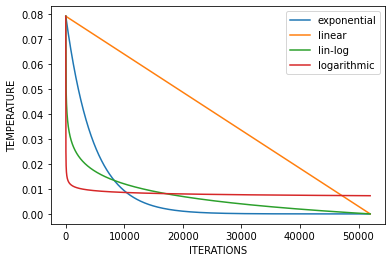

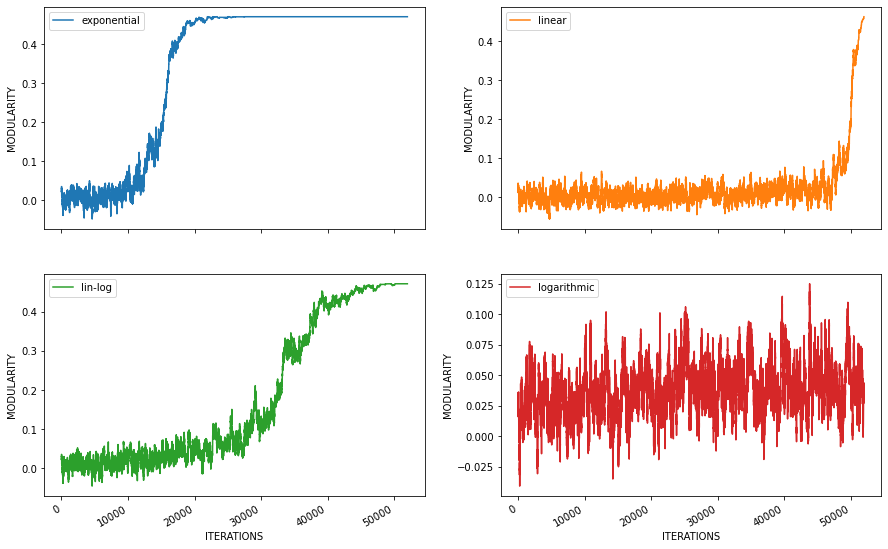

In [27]:
#COOLING FUNCTIONS BEHAVIOUR

methods = ["exponential", "linear", "lin-log", "logarithmic"]
tem = pd.DataFrame()
modularities=pd.DataFrame()
N_sim=228**2

for m in methods:
    #compute the temperature for each method m and iteration i
    tem[m] = [cooling_sched(t0, tf, i, N_sim, m) for i in range(N_sim+1)] 
    #compute the modularity for each method m 
    modularities[m]= simulated_annealing(dataset_r, 228,  "DURATION", m , t0, tf, N_sim, all_mod=True)
           
tem.plot(xlabel = "ITERATIONS", ylabel = "TEMPERATURE")
modularities.plot(xlabel = "ITERATIONS", ylabel = "MODULARITY", subplots=True, layout=(2,2), figsize=(15, 10))

With a constant number of iterations one can easily notice that not all the cooling functions converge to a certain modularity value.                                          
The maximum modularity value is reached by the first three methods (exponential, linear and log-linear) even if the number of iterations needed varies considerably. The chosen method is the exponential one since it requires only 25000 iterations to converge.

In [28]:
#MODULARITY OPTIMIZATION TO FIND THE BEST NUMBER OF COMMUNITIES

def modularity_optimization(dataset_r, n_nodes, weights_name, cooling_function, t0, tf, N):

    mod_pre  = -10000            # <- modularity at the previous iteration
    mod_next = 0                 # <- modularity at the actual iteration
    C = 1                        # <- starting number of communities
    communities = [0]*n_nodes    # <- list of the 228 communities labels
    labs  = [0]                  # <- labels of the communities generated by the best bipartition at the previous iteration
    sub_nodes = {str(0): 0}
    mod = {str(0): [0]}
    bipartitions={str(0): 0}
    comm={str(0): 0}
    
    #While the modularity (utility function) increases:
    while mod_pre < mod_next:    
        mod_pre = mod_next       
        
        #For each communities c whose indexes go from 0 to C-1:
        for c in range(C):      
            comm[str(c)]=communities.copy()
            
            # - if the community c is one of those generated during the previous iteration then apply the SA algorithm to find its suboptimal bipartition
            if c in labs:         
                sub_nodes[str(c)]=[i for i,x in enumerate(communities) if x==c]
                sub_df = rename(dataset_r[(dataset_r['SOURCE'].isin(sub_nodes[str(c)]))&
                                          (dataset_r['TARGET'].isin(sub_nodes[str(c)]))].reset_index(drop=True), ["SOURCE", "TARGET"])
                bipartitions[str(c)], _ = simulated_annealing(sub_df, len(sub_nodes[str(c)]), weights_name,  
                                                       cooling_function, t0, tf, N_sim=N)
               
                community_2 = [c if e == 0 else C if e == 1 else None for e in bipartitions[str(c)]]
                for j in range(len(sub_nodes[str(c)])):
                    comm[str(c)][sub_nodes[str(c)][j]] = community_2[j]
                mod[str(c)] = modularity(dataset_r, np.array(comm[str(c)]), weights_name) #compute the overall modularity
                
            # - otherwise use the suboptimal bipartition obtained during one of the previous iterations.
            else:
                community_3 = [c if e == 0 else C if e == 1 else None for e in bipartitions[str(c)]]
                for j in range(len(sub_nodes[str(c)])):
                    comm[str(c)][sub_nodes[str(c)][j]] = community_3[j]
                mod[str(c)] = modularity(dataset_r, np.array(comm[str(c)]), weights_name) #compute the overall modularity
        
        #The optimal partition of nodes is the one which maximizes the modularity
        best_c = str(max(mod.items(), key=lambda x: x[1])[0])
        mod_next = mod[best_c].copy()
        labs = [int(best_c), C]
        C = C+1
        
        if mod_next>mod_pre:
            communities=comm[best_c].copy() 
            print('number of community:', C)
        else:
            communities=communities.copy()
            print('number of community:', C-1)      
        time.sleep(1)

    return communities, mod_pre

In [29]:
SA_communities, SA_modularity = modularity_optimization(dataset_r, 228,  "DURATION", "exponential", t0, tf, N=25000)
#The overall sloweness is due to:
# - the number of nodes;
# - the number of iterations.

100%|██████████| 25000/25000 [02:20<00:00, 178.15it/s]


number of community: 2


100%|██████████| 25000/25000 [02:56<00:00, 141.26it/s]


number of community: 3


100%|██████████| 25000/25000 [02:16<00:00, 182.54it/s]


number of community: 4


100%|██████████| 25000/25000 [02:04<00:00, 200.79it/s]


number of community: 5


100%|██████████| 25000/25000 [02:03<00:00, 202.07it/s]


number of community: 6


100%|██████████| 25000/25000 [02:23<00:00, 174.45it/s]


number of community: 7


100%|██████████| 25000/25000 [02:43<00:00, 152.51it/s]


number of community: 8


100%|██████████| 25000/25000 [02:35<00:00, 161.14it/s]


number of community: 8


### 2.2 Comparison between community detection algorithms
- Modularity optimization using the simulated annealing;
- Louvain community detection algorithm.

In [30]:
edges = nx.from_pandas_edgelist(dataset_r.iloc[:, 0:3], 'SOURCE', 'TARGET', 'DURATION')

np.random.seed(40)
partition = community.best_partition(edges, weight='DURATION')
LV_modularity = community.modularity(partition, edges, weight='DURATION')

LV_communities = pd.DataFrame.from_dict(partition, orient='index', columns=['Community']).sort_index()
LV_modularity, SA_modularity
#The solutions found using the two different methods have similar modularity value.

(0.6581291019683588, 0.6468577540871249)

In [31]:
print(len(LV_communities['Community'].unique()), len(set(SA_communities)))
#Number of communities found by the two methods.

6 8


### 2.3 Communities characterization

In [32]:
meta["COMMUNITY"] = SA_communities
meta

,NODE_ID,CLASS_NAME,GENDER,CLASS_YEAR,COMMUNITY
0,1426,5B,M,5,0
1,1427,5B,F,5,0
2,1428,5B,M,5,0
3,1429,5B,F,5,0
4,1431,5B,F,5,0
...,...,...,...,...,...
223,1916,2A,M,2,6
224,1917,2A,F,2,6
225,1919,2A,M,2,6
226,1920,1B,F,1,3


In [33]:
#HYPOTESIS TESTING FOR THE CONCENTRATION OF FEATURES INSIDE A COMMUNITY
#calculate the probability that the number of nodes that appear in that community with that feature occured by chance

def charact(feature, meta):
    S = meta.shape[0] #number of nodes in the whole dataset
    final_data = {"COMMUNITY": [], "VALUE": [], "FREQUENCY": [], "P-VALUE": []}
    
    for community in set(meta["COMMUNITY"]):
        subset = meta[meta['COMMUNITY']==community]
        feat_values = np.unique(subset[feature])
        K = subset.shape[0]  #number of nodes inside the specified community        
                
        for value in feat_values:
            C=int(Counter(meta[feature])[str(value)])   #no. nodes with that value of that feature in the whole dataset
            c=int(Counter(subset[feature])[str(value)]) #no. nodes with that value of that feature in the specified community

            if c<C*K/S:
                pvalue=hypergeom.cdf(c, S, C, K)
            else:
                pvalue=1-hypergeom.cdf(c, S, C, K)  
                
            final_data["COMMUNITY"].append(community)
            final_data["VALUE"].append(value)
            final_data["FREQUENCY"].append(round(c, 0))
            final_data["P-VALUE"].append(round(pvalue, 3))
    return pd.DataFrame.from_dict(final_data)

In [34]:
for feature in ["CLASS_NAME", "CLASS_YEAR", "GENDER"]:
    print(charact(feature, meta))

    COMMUNITY VALUE  FREQUENCY  P-VALUE
0           0    5B         22    0.000
1           1    1A         23    0.000
2           1    3A         23    0.000
3           1    3B         21    0.000
4           2    2B         26    0.000
5           3    1B         25    0.000
6           4    4A         21    0.000
7           4    4B          2    0.613
8           5    5A         21    0.000
9           6    2A         23    0.000
10          7    4B         20    0.000
11          7    5B          1    0.347
   COMMUNITY VALUE  FREQUENCY  P-VALUE
0          0     5         22    0.000
1          1     1         23    0.001
2          1     3         44    0.000
3          2     2         26    0.000
4          3     1         25    0.000
5          4     4         23    0.000
6          5     5         21    0.000
7          6     2         23    0.000
8          7     4         20    0.000
9          7     5          1    0.058
    COMMUNITY    VALUE  FREQUENCY  P-VALUE
0       